<a href="https://colab.research.google.com/github/jasdavis10/Deep-Reinforcement-Learning-for-Automated-Stock-Trading/blob/main/Copy_of_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
! pip install gymnasium
! pip install stable_baselines3

import numpy as np
import pandas as pd
import yfinance as yf
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback

In [10]:
# List of stocks in the Dow Jones 30
tickers = [
    'COF'
]


# Get historical data from Yahoo Finance and save it to dictionary
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = {}
    for ticker in tickers:
        stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Call the function to get data
stock_data = fetch_stock_data(tickers, '2000-01-01', '2025-01-10')

[*********************100%***********************]  1 of 1 completed


- Training data shape for COF: (5536, 5)
- Validation data shape for COF: (251, 5)
- Test data shape for COF: (507, 5)



Price,Close,High,Low,Open,Volume
Ticker,COF,COF,COF,COF,COF
Date,,,,,
2025-01-02,178.710007,182.190002,177.089996,180.000000,1792900
2025-01-03,180.429993,180.520004,177.220001,180.000000,1886700
2025-01-06,183.520004,185.699997,181.809998,184.979996,2277900
2025-01-07,181.889999,185.389999,180.619995,184.979996,2508300
2025-01-08,180.139999,181.389999,178.869995,180.449997,2355400


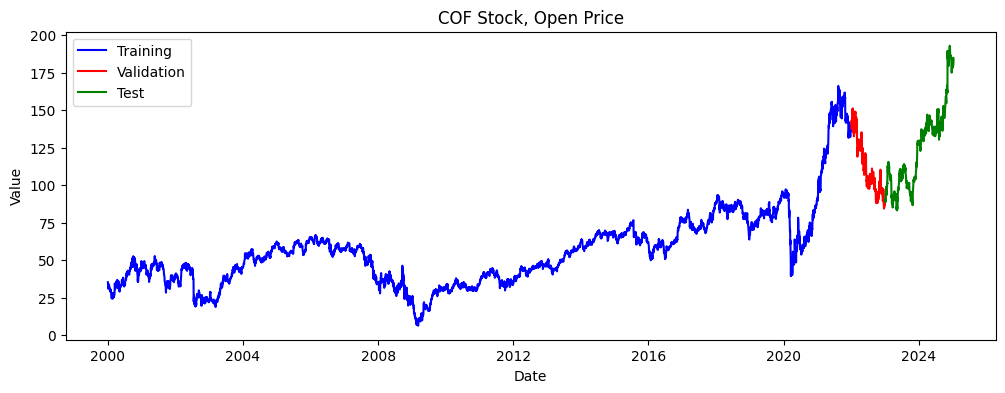

In [11]:
# split the data into training, validation and test sets
training_data_time_range = ('2000-01-01', '2021-12-31')
validation_data_time_range = ('2022-01-01', '2022-12-31')
test_data_time_range = ('2023-01-01', '2025-01-10')

# split the data into training, validation and test sets
training_data = {}
validation_data = {}
test_data = {}

for ticker, df in stock_data.items():
    training_data[ticker] = df.loc[training_data_time_range[0]:training_data_time_range[1]]
    validation_data[ticker] = df.loc[validation_data_time_range[0]:validation_data_time_range[1]]
    test_data[ticker] = df.loc[test_data_time_range[0]:test_data_time_range[1]]

# print shape of training, validation and test data
ticker = 'COF'
print(f'- Training data shape for {ticker}: {training_data[ticker].shape}')
print(f'- Validation data shape for {ticker}: {validation_data[ticker].shape}')
print(f'- Test data shape for {ticker}: {test_data[ticker].shape}\n')

# Display the first 5 rows of the data
display(stock_data['COF'].tail())
print('\n')

# Plot:
plt.figure(figsize=(12, 4))
plt.plot(training_data[ticker].index, training_data[ticker]['Open'], label='Training', color='blue')
plt.plot(validation_data[ticker].index, validation_data[ticker]['Open'], label='Validation', color='red')
plt.plot(test_data[ticker].index, test_data[ticker]['Open'], label='Test', color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'{ticker} Stock, Open Price')
plt.legend()
plt.show()

In [12]:
## Add Features
'''
MACD (Moving Average Convergence Divergence): This indicator involves computing the 12-day and 26-day Exponential Moving Averages (EMAs) to determine the MACD line, and then applying a 9-day EMA to the MACD line to generate the Signal line. The MACD and Signal lines help in identifying potential buy or sell signals based on their crossovers.
RSI (Relative Strength Index): We calculate the RSI with a 14-day window to gauge the momentum of price movements. This indicator helps to identify overbought or oversold conditions by measuring the speed and change of price movements.
CCI (Commodity Channel Index): This indicator assesses the deviation of the price from its average, which helps in identifying new trends or extreme conditions. We use a 20-day window to calculate the CCI.
ADX (Average Directional Index): To measure the strength of a trend, we compute the ADX using a 14-day window. This involves calculating the Directional Movement (DM) indicators and the Average True Range (ATR) to determine the ADX value.
'''

def add_technical_indicators(df):

    df = df.copy()

    # Calculate EMA 12 and 26 for MACD
    df.loc[:, 'EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df.loc[:, 'EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df.loc[:, 'MACD'] = df['EMA12'] - df['EMA26']
    df.loc[:, 'Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Calculate RSI 14
    rsi_14_mode = True
    delta = df['Close'].diff()
    if rsi_14_mode:
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
    else:
        up = delta.where(delta > 0, 0)
        down = -delta.where(delta < 0, 0)
        rs = up.rolling(window=14).mean() / down.rolling(window=14).mean()
    df.loc[:, 'RSI'] = 100 - (100 / (1 + rs))

    # Calculate CCI 20
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
    df.loc[:, 'CCI'] = (tp - sma_tp) / (0.015 * mean_dev)

    # Calculate ADX 14
    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    df.loc[:, '+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    df.loc[:, '-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    tr = pd.concat([df['High'] - df['Low'], np.abs(df['High'] - df['Close'].shift(1)), np.abs(df['Low'] - df['Close'].shift(1))], axis=1).max(axis=1)
    atr = tr.ewm(span=14, adjust=False).mean()
    df.loc[:, '+DI'] = 100 * (df['+DM'].ewm(span=14, adjust=False).mean() / atr)
    df.loc[:, '-DI'] = 100 * (df['-DM'].ewm(span=14, adjust=False).mean() / atr)
    dx = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df.loc[:, 'ADX'] = dx.ewm(span=14, adjust=False).mean()

    # Drop NaN values
    df.dropna(inplace=True)

    # Keep only the required columns
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX']]

    return df

# -----------------------------------------------------------------------------

# add technical indicators to the training data for each stock
for ticker, df in training_data.items():
    training_data[ticker] = add_technical_indicators(df)

# add technical indicators to the validation data for each stock
for ticker, df in validation_data.items():
    validation_data[ticker] = add_technical_indicators(df)

# add technical indicators to the test data for each stock
for ticker, df in test_data.items():
    test_data[ticker] = add_technical_indicators(df)

# print the first 5 rows of the data
print(f'- Training data shape for {ticker}: {training_data[ticker].shape}')
print(f'- Validation data shape for {ticker}: {validation_data[ticker].shape}')
print(f'- Test data shape for {ticker}: {test_data[ticker].shape}\n')

display(test_data[ticker].tail())

- Training data shape for COF: (5517, 10)
- Validation data shape for COF: (232, 10)
- Test data shape for COF: (488, 10)



Price,Open,High,Low,Close,Volume,MACD,Signal,RSI,CCI,ADX
Ticker,COF,COF,COF,COF,COF,,,,,
Date,,,,,,,,,,
2025-01-02,180.000000,182.190002,177.089996,178.710007,1792900,-0.478005,0.342290,35.830136,-59.950377,37.219215
2025-01-03,180.000000,180.520004,177.220001,180.429993,1886700,-0.422819,0.189268,41.793301,-53.060852,32.951956
2025-01-06,184.979996,185.699997,181.809998,183.520004,2277900,-0.128267,0.125761,48.269966,48.104810,34.093651
2025-01-07,184.979996,185.389999,180.619995,181.889999,2508300,-0.026059,0.095397,44.675928,31.847181,35.083119
2025-01-08,180.449997,181.389999,178.869995,180.139999,2355400,-0.085287,0.059260,48.146841,-26.527408,35.940659
